# Module 4. N-grams, traditional word vectors, and neural embeddings

In [1]:
import os
import re
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from langdetect import detect
from stemmer import UkrainianStemmer

from ipywidgets import IntProgress
from IPython.display import display

from gensim.models import KeyedVectors
from gensim.test.utils import datapath

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

%matplotlib inline
sns.set()

# Load the data

In [2]:
def read_file(path):
    with open(path) as f:
        return f.read()

def parse_content(topic, txt):
    obj = {"id": [], "content": [],}
    next_request = re.search(r"\d{7}\n", txt)
    while next_request:
        start = next_request.start()
        id = txt[:7]
        txt = txt[7:]
        
        next_request = re.search(r"\d{7}\n", txt)
        if not next_request:
            break
            
        start = next_request.start()
            
        request_content = txt[1:start]
        
        obj["id"].append(id)
        obj["content"].append(request_content)
        
        txt = txt[start:]
        
    obj["topic"] = [topic] * len(obj["id"])
    return obj
    
def read_requests(folder):
    requests = {"id": [], "content": [], "topic": []}
    filenames = os.listdir(folder)
    
    progress_bar = IntProgress(min=0, max=len(filenames), description='Reading file:', bar_style='info')
    display(progress_bar)
    
    for filename in filenames:
        path = os.path.join(folder, filename)
        
        file_content = read_file(path)
        
        filename_without_ext, _ = os.path.splitext(filename)
        parsed_content = parse_content(filename_without_ext, file_content)
            
        requests["id"] += parsed_content["id"]
        requests["content"] += parsed_content["content"]
        requests["topic"] += parsed_content["topic"]
            
        progress_bar.value += 1
    
    return pd.DataFrame.from_dict(requests)

In [3]:
df = read_requests('./1551')

IntProgress(value=0, bar_style='info', description='Reading file:', max=188)

In [4]:
df.head()

,id,content,topic
0,3096223,"Хочу Вас спитати, маю я право на субсидію чи н...",Розрахунки--нарахування-та-перерахунок-субсидій
1,3401866,"Добрый день, подскажите как оформить субсидию ...",Розрахунки--нарахування-та-перерахунок-субсидій
2,3382672,При подаче декларации и заявления на субсидию ...,Розрахунки--нарахування-та-перерахунок-субсидій
3,3354708,Питання про надання субсидій. Чому ходять чутк...,Розрахунки--нарахування-та-перерахунок-субсидій
4,3350015,Цього року я подала поштою необхідні документи...,Розрахунки--нарахування-та-перерахунок-субсидій


In [5]:
def count_plot(df, column, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    sns.set(font_scale = 2)
    sns.set_style('whitegrid')
    return sns.countplot(y=column, data=df, order = df[column].value_counts().index)

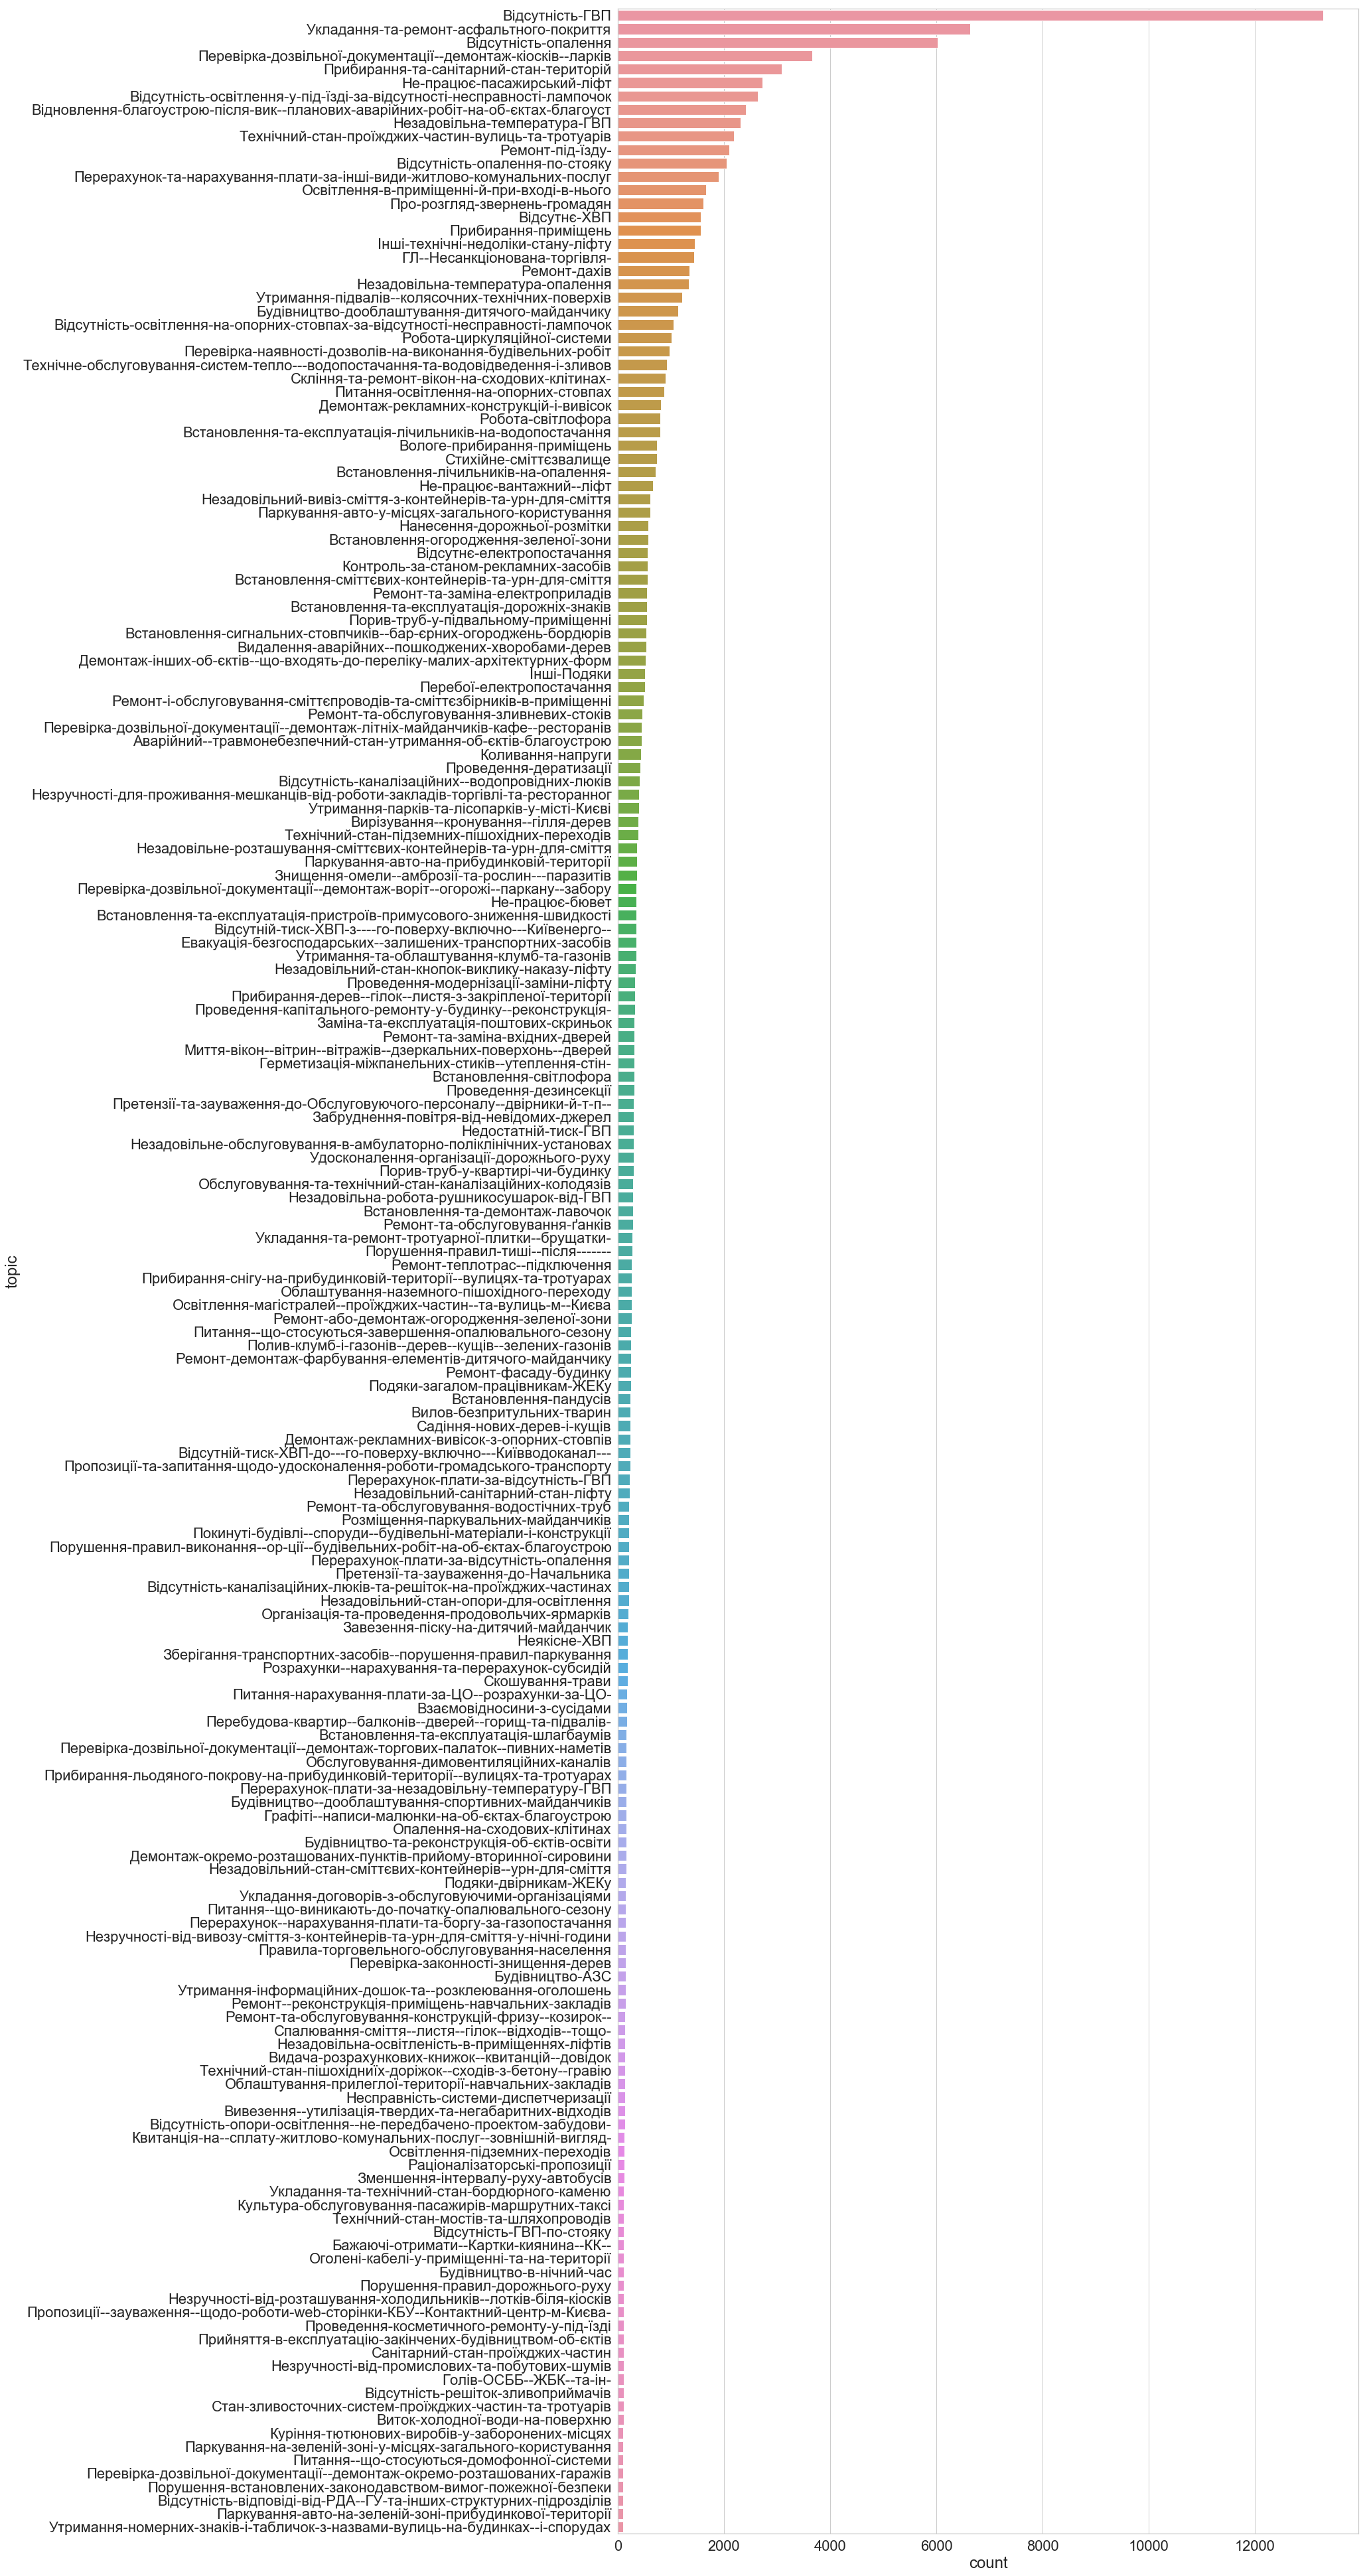

In [6]:
ax = count_plot(df, "topic", figsize=(20, 70))

# Preprocessing

[Article about preprocessing](https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908)

Stop words are taken from "Mining massive datasets" UCU [course project](https://github.com/andreyurkiv/mmds-word-embeddings/blob/master/data/stop_words)

For language detection [langdetect](https://pypi.org/project/langdetect/) package is used.

In [7]:
stop_words = read_file('./stop_words.txt')
stop_words = stop_words.split('\n')

In [8]:
df["content"] = df["content"].apply(lambda x: x.lower()) # to lower case
df["content"] = df["content"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) # remove punctuation
df["content"] = df["content"].apply(lambda x: re.sub(r"\d+", "", x)) # remove digits
df["content"] = df["content"].apply(lambda x: x.strip()) # remove multiple spaces
df["content"] = df["content"].apply(lambda x: re.sub(r"\n+", " ", x)) # remove blank lines
df["content"] = df["content"].apply(
    lambda x: ' '.join(
        list(filter(lambda x: x != '', [word if word not in stop_words else '' for word in x.split(' ')]))
    )
) # remove stop words

In [9]:
df.iloc[0]["content"]

'хочу спитати маю право субсидію квартирі прописані дочка батько помер мав інваліда війни групипільги вдова померлого оформила трикімнатна крартира місяць рахунки більші мою пенсіюдочка навчається доходів моєї пенсії повагою гончаренко олена віталіївна конт'

In [10]:
def detect_lang(df):
    progress_bar = IntProgress(min=0, max=df.shape[0], description='Detecting:', bar_style='info')
    display(progress_bar)

    def check_lang(string):
        nonlocal progress_bar 
        progress_bar.value += 1
        try:
            return detect(string)
        except Exception as e:
            return 'ru'

    df["language"] = ''
    df["language"] = df["content"].apply(check_lang)

    print("langdetect applied")

    df["language"] = df["content"].apply(
        lambda x: 'ru' if 
            'ъ' in x or \
            'ё' in x or \
            'ы' in x or \
            'э' in x else 'uk'
    )
    
    print("specific chars checked")
    
    return df

In [11]:
# remove non ukrainian requests
df = detect_lang(df)

IntProgress(value=0, bar_style='info', description='Detecting:', max=114882)

langdetect applied
specific chars checked


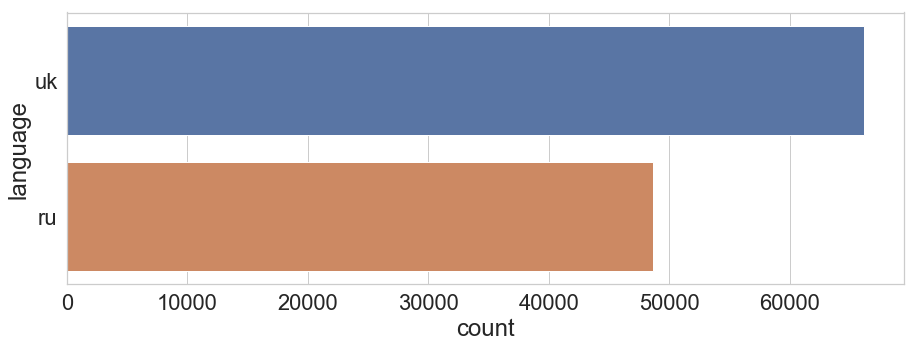

In [12]:
ax = count_plot(df, "language", figsize=(15, 5))

In [13]:
ukrainean_only = df[df["language"] == "uk"]
ukrainean_only = ukrainean_only.reset_index(drop=True)
print("Number of requests after russian language removal: {}".format(df.shape[0]))
ukrainean_only.head()

Number of requests after russian language removal: 114882


,id,content,topic,language
0,3096223,хочу спитати маю право субсидію квартирі пропи...,Розрахунки--нарахування-та-перерахунок-субсидій,uk
1,3354708,питання надання субсидій ходять чутки продажі ...,Розрахунки--нарахування-та-перерахунок-субсидій,uk
2,3350015,подала поштою необхідні документи заяву деклар...,Розрахунки--нарахування-та-перерахунок-субсидій,uk
3,3223482,відділі супсидій повинні автоматично перерахув...,Розрахунки--нарахування-та-перерахунок-субсидій,uk
4,3075714,оформити звертатися оформлення субсидії працюю...,Розрахунки--нарахування-та-перерахунок-субсидій,uk


# Model preparation

[Article](https://radimrehurek.com/gensim/models/word2vec.html)

In [14]:
def sent2vecs(model, sentance):
    w_sum = np.zeros((300,))
    for word in sentance.split(' '):
        vec = None
        try:
            vec = model.get_vector(word)
        except:
            vec = np.zeros((300,)) 
        w_sum = np.add(w_sum, vec)
    return w_sum

In [15]:
w2v = KeyedVectors.load_word2vec_format('./news.lowercased.tokenized.word2vec.300d')

In [16]:
ukrainean_only["vec"] = ukrainean_only["content"].apply(lambda x: sent2vecs(w2v, x))
ukrainean_only.head()

,id,content,topic,language,vec
0,3096223,хочу спитати маю право субсидію квартирі пропи...,Розрахунки--нарахування-та-перерахунок-субсидій,uk,"[-20.09709607809782, -9.19565775571391, -6.974..."
1,3354708,питання надання субсидій ходять чутки продажі ...,Розрахунки--нарахування-та-перерахунок-субсидій,uk,"[-17.16897764056921, 10.409285932779312, -7.27..."
2,3350015,подала поштою необхідні документи заяву деклар...,Розрахунки--нарахування-та-перерахунок-субсидій,uk,"[-28.98099668137729, 37.22484563291073, -4.299..."
3,3223482,відділі супсидій повинні автоматично перерахув...,Розрахунки--нарахування-та-перерахунок-субсидій,uk,"[-7.803874731063843, -6.550673246383667, -2.54..."
4,3075714,оформити звертатися оформлення субсидії працюю...,Розрахунки--нарахування-та-перерахунок-субсидій,uk,"[-13.233569964766502, -0.11370785534381866, 1...."


In [17]:
train, test = train_test_split(ukrainean_only, random_state=42)

# KNN classifier

In [18]:
knn = KNeighborsClassifier(n_neighbors=20, metric='cosine')
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [19]:
knn.fit(np.vstack(train["vec"].values), train["topic"].values)
prediction = knn.predict(np.vstack(test["vec"].values))
print("Accuracy of KNN is {}".format(len(test[test["topic"] == prediction]) / len(test)))

Accuracy of KNN is 0.4357099697885196


# Improvements:

- Lemmatisation
- Logistic Regression
- TF-IDF

### Apply [UkrainianStemmer](https://github.com/Amice13/ukr_stemmer)

file `stammer.py` actually copied from UkrainianStemmer git repo.

In [20]:
uk_lammatized = ukrainean_only.copy()

uk_lammatized["content"] = uk_lammatized["content"].apply(
    lambda x: ' '.join(
        list(filter(lambda x: x != '', [UkrainianStemmer(word).stem_word() for word in x.split(' ')]))
    )
)

In [21]:
w2v_lematized = KeyedVectors.load_word2vec_format('./news.lowercased.lemmatized.word2vec.300d')

uk_lammatized["vec"] = uk_lammatized["content"].apply(lambda x: sent2vecs(w2v_lematized, x))
uk_lammatized.head()

,id,content,topic,language,vec
0,3096223,хоч спит ма прав субсид квартир прописан дочк ...,Розрахунки--нарахування-та-перерахунок-субсидій,uk,"[0.620191864669323, 0.8297549672424793, -10.73..."
1,3354708,питанн наданн субсид ход чутк продаж квартир я...,Розрахунки--нарахування-та-перерахунок-субсидій,uk,"[-1.7095820531249046, -5.290431991219521, -5.6..."
2,3350015,подал пошт необхідн документ заяв декларац при...,Розрахунки--нарахування-та-перерахунок-субсидій,uk,"[5.300753079354763, -1.777156083844602, -0.741..."
3,3223482,відділ супсид повинн автоматичн перерахув дос ...,Розрахунки--нарахування-та-перерахунок-субсидій,uk,"[1.6343108899891376, 4.024987012147903, -3.718..."
4,3075714,оформит зверт оформленн субсиді працю сто облі...,Розрахунки--нарахування-та-перерахунок-субсидій,uk,"[4.537837982177734, -2.8563930094242096, -2.19..."


In [22]:
train_lem, test_lem = train_test_split(uk_lammatized, random_state=42)

In [23]:
knn = KNeighborsClassifier(n_neighbors=20, metric='cosine')
knn.fit(np.vstack(train_lem["vec"].values), train_lem["topic"].values)
prediction = knn.predict(np.vstack(test_lem["vec"].values))

print("Accuracy of KNN is {}".format(len(test_lem[test_lem["topic"] == prediction]) / len(test_lem)))

Accuracy of KNN is 0.32265861027190335


In [24]:
try:
    w2v_lematized.get_vector('питанн')
except:
    print("Word {} not in w2v model".format('питанн'))

Word питанн not in w2v model


Stamming gave poor result, since such words as `питанн` or `наданн` can't be found in vector space. Actually this is the problem of stemmer itself. But that is the only one I actually found.

### Use Random forest

In [25]:
clf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0)
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [26]:
clf.fit(np.vstack(train["vec"].values), train["topic"].values)
prediction = clf.predict(np.vstack(test["vec"].values))
print("Accuracy of Random forest is {}".format(len(test[test["topic"] == prediction]) / len(test)))

Accuracy of Random forest is 0.4383081570996979


### Use TF-IDF

In [41]:
tfidf = TfidfVectorizer(min_df=0.01)

train_tfidf = tfidf.fit_transform(train["content"])
test_tfidf = tfidf.transform(test["content"])

In [43]:
knn = KNeighborsClassifier(n_neighbors=20, metric='cosine')
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [44]:
knn.fit(train_tfidf, train["topic"].values)
prediction = knn.predict(test_tfidf)
print("Accuracy of KNN is {}".format(len(test[test["topic"] == prediction]) / len(test)))

Accuracy of KNN is 0.3834441087613293


### Use NN

In [31]:
nn = MLPClassifier(hidden_layer_sizes=(300, 300,), batch_size = 128, activation='relu', solver='adam')
nn

MLPClassifier(activation='relu', alpha=0.0001, batch_size=128, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300, 300), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [32]:
nn.fit(np.vstack(train["vec"].values), train["topic"].values)
prediction = nn.predict(np.vstack(test["vec"].values))
print("Accuracy of Neural netrowrk is {}".format(len(test[test["topic"] == prediction]) / len(test)))

Accuracy of Neural netrowrk is 0.5293655589123867


# Conclusion:
    
As one can see Neural net has the best results, while KNN with TF-IDF the worst